In [ ]:
# import main
# import lasio
# model_path = "..\\tasks\\task 6\\Data\\modelling\\"
# main.create_csv_from_las_modeling(model_path,'modeling_aps.csv')pd.datetime.strptime(x, '%Y.%m.%d')

In [53]:
import numpy as np
import pandas as pd
import main
# данные от организаторов
water_content_data = pd.read_csv(main.data_dir + "\\water_content.csv", delimiter=';')
water_content_data = water_content_data.rename(columns={'Скважина': main.keys_dict[main.kid_well]})
water_content_data = water_content_data.rename(columns={' Начальная обводненность ': 'WC'})
water_content_data = water_content_data.rename(columns={'Дата запуска': 'date_start'})
water_content_data = water_content_data.rename(columns={'date_start': 'DATE_START_WC'})
water_content_data = water_content_data.rename(columns={'well_name': 'WELL_NAME'})
water_content_data['DATE_START_WC'] = pd.to_datetime(water_content_data['DATE_START_WC'])
water_content_data['WELL_NAME'] = water_content_data['WELL_NAME'].astype('str')
water_content_data.head(n=5)

,WELL_NAME,DATE_START_WC,WC
0,380,1905-04-07,0.49
1,379,2006-01-12,0.30
2,370,2007-01-02,0.13
3,417,2007-01-03,0.08
4,389,2007-01-08,0.22


In [54]:
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
perf_data = pd.read_csv(main.data_dir + '\\perforation_wellname.csv' , delimiter=';', date_parser=dateparse)
del perf_data['Пласт']
del perf_data['ГИС']
del perf_data['Тип']
del perf_data['Перфоратор']
del perf_data['N отв']
del perf_data['Hнач(abs,тр)']
del perf_data['Hкон(abs,тр)']
del perf_data['Hнач(abs)']
del perf_data['Hкон(abs)']
del perf_data['Плотность']
del perf_data['Открыт']
perf_data = perf_data.rename(columns={'Скважина': 'WELL_NAME'})
perf_data = perf_data.rename(columns={'Дата': 'PERF_DATE'})
perf_data = perf_data.rename(columns={'Hнач(md)':'DEPTH_TOP'})
perf_data = perf_data.rename(columns={'Hкон(md)':'DEPTH_BOTTOM'})
perf_data['PERF_DATE'] = pd.to_datetime(perf_data['PERF_DATE'])
perf_data['WELL_NAME'] = perf_data['WELL_NAME'].astype('str')
perf_data.head(n=5)

,WELL_NAME,PERF_DATE,DEPTH_TOP,DEPTH_BOTTOM
0,312,2013-06-28,2671.0,2687.0
1,313,2014-10-06,3123.0,3133.0
2,314,2014-02-04,2758.4,2769.0
3,315ST3,2013-12-29,2847.0,2857.0
4,316,2013-10-16,3071.0,3082.0


In [64]:
merge_data = pd.merge(water_content_data, perf_data, on='WELL_NAME')
merge_data.head()
print(merge_data.count())
merge_data.head(n=2)

WELL_NAME        327
DATE_START_WC    327
WC               327
PERF_DATE        327
DEPTH_TOP        327
DEPTH_BOTTOM     327
dtype: int64


,WELL_NAME,DATE_START_WC,WC,PERF_DATE,DEPTH_TOP,DEPTH_BOTTOM
0,380,1905-04-07,0.49,2012-05-31,2720.0,2733.0
1,379,2006-01-12,0.30,2006-10-22,2756.0,2770.0


In [65]:
merge_data['DIFF'] = (merge_data['DATE_START_WC'] - merge_data['PERF_DATE']).dt.days
perf_data_wc = merge_data[merge_data['DIFF'] > -90]

Проверка на расчитанных данных

In [66]:
# удаляем с несколькими перфорациями
well_name_list = perf_data_wc['WELL_NAME'].value_counts().index.tolist()
print(len(well_name_list))
for name in well_name_list:
    temp_data = perf_data_wc[perf_data_wc['WELL_NAME'] == name]
    if(temp_data['WELL_NAME'].count() > 1):
        print ('delete', name)
        perf_data_wc = perf_data_wc[perf_data_wc['WELL_NAME'] != name]
well_name_list = perf_data_wc['WELL_NAME'].value_counts().index.tolist()
print(len(well_name_list))

58
delete 397
delete 538
56


In [67]:
perf_data_wc.head(n=2)

,WELL_NAME,DATE_START_WC,WC,PERF_DATE,DEPTH_TOP,DEPTH_BOTTOM,DIFF
3,370,2007-01-02,0.13,2007-02-20,3209.0,3223.0,-49
4,417,2007-01-03,0.08,2007-03-15,2840.5,2853.0,-71


Проверка на данных ГИС

In [68]:
las_out_file_name = 'AllGisParams\\fake_gis_las_all_out.csv'
global_data = pd.read_csv(las_out_file_name, delimiter=';')
global_data['WELL_NAME'] = global_data['WELL_NAME'].astype('str')
global_data['WELL_NAME_UWI'] = global_data['WELL_NAME_UWI'].astype('str')

In [31]:
global_data.head(n=5)

,WELL_NAME,WELL_NAME_UWI,DEPT,KINT,R05,R20,R14,R10,F07,F10,...,GZ2,GZ4,GZ1,CILD,PROX,LLD,GZ7,APS,KPS,GZ5
0,300,198,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,300,198,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,300,198,4.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,300,198,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,300,198,4.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
params_name = ['CILD']
real_data_na[params_name]

,CILD
25344,139.0
25345,139.0
25346,139.0
25347,138.5
25348,138.0
25349,138.5
25350,139.0
25351,140.0
25352,141.0
25353,141.5


In [90]:
all_params = ['WELL_NAME', 'WELL_NAME_UWI', 'DEPT']
all_params.extend(params_name)
las_data = global_data[all_params].copy()
las_data['WELL_NAME'] = las_data['WELL_NAME'].astype('str')
las_data['WELL_NAME_UWI'] = las_data['WELL_NAME_UWI'].astype('str')
las_data.head(n=5)
# Объединяем данные
real_data = pd.merge(las_data, perf_data_wc, on='WELL_NAME')
real_data_na = real_data.dropna()

real_data_na = real_data_na[(real_data_na['CILD'] >= 0) & (real_data_na['CILD'] < 250)]

from sklearn.preprocessing import StandardScaler
print('real, min = ', real_data_na[params_name].min(), ' max = ', real_data_na[params_name].max())
real_data_na[params_name] = StandardScaler().fit_transform(real_data_na[params_name])
print('scaler, min = ', real_data_na[params_name].min(), ' max = ', real_data_na[params_name].max())
# нормализуем
print('real, min = ', real_data_na[params_name].min(), ' max = ', real_data_na[params_name].max())

real, min =  CILD    0.0
dtype: float64  max =  CILD    249.6
dtype: float64
scaler, min =  CILD   -3.187337
dtype: float64  max =  CILD    3.273664
dtype: float64
real, min =  CILD   -3.187337
dtype: float64  max =  CILD    3.273664
dtype: float64


In [95]:
# объединение данных по всем параметрам
min_count_val_in_data = 10
count_val = 100
print('Start union table')

print(len(real_data['WELL_NAME'].value_counts()))
# Преобразуем в данные для обучения
dev_path = "..\\tasks\\task 6\\data\\dev\\"
well_name_list = real_data_na['WELL_NAME_UWI'].value_counts().index.tolist()

x_values = []
for param in params_name:
    params_name_file = (param.replace(':','')).lower()
    print('Convert ', param, 'start')

#     [x_values_temp, y_values, y_names] = main.ConvertDataToLearningByStdParams(real_data_na, param, dev_path,
#                                                            min_count_val_in_data)
    [x_values_temp, y_values, y_names] = main.ConvertDataToLearningPerforation(real_data_na, param,
                                                               min_count_val_in_data, count_val)
    if (len(x_values) > 0):
        for src, res in zip(x_values_temp, x_values):
            res.extend(src)
            #print('res = ',len(res), 'src = ', len(src))
    else:
        x_values = x_values_temp.copy()
                
    print('length =', len(x_values), len(y_values), len(x_values[0]))
    

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score

y_values_r = y_values
x_train, x_hold, y_train, y_hold = train_test_split(x_values, y_values_r, test_size=0.3, random_state=17)

Start union table
51
Convert  CILD start
0  of  51
20  of  51
40  of  51
end ConvertDataToLearning
length = 51 51 100


In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def data_analize_func(predict_for_analize, file_name = ''):
    # подготовка данных
    data_for_analize = predict_for_analize.sort_values(by=['y_hold'])
    data_for_analize['x_axis'] = [x for x in range(len(predict_for_analize['y_hold']))]
    data_for_analize.head()
    if file_name != '':
        data_for_analize.to_csv('AllGisParams/' + file_name, index=False, sep = ';')
    
    # построение графиков
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_predict'], color = 'blue')
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_hold'], color = 'red')
    plt.show()
    
    # regression metrics
    print('MSE                      = '+ str(mean_squared_error(data_for_analize['y_hold'], 
                                                                data_for_analize['y_predict'])))
    print('MAE                      = '+ str(mean_absolute_error(data_for_analize['y_hold'], 
                                                                 data_for_analize['y_predict'])))
    print('r2_score                 = '+ str(r2_score(data_for_analize['y_hold'], 
                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')
    print('explained_variance_score = '+ str(explained_variance_score(data_for_analize['y_hold'], 
                                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')

In [97]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

forest_reg =  RandomForestRegressor(n_estimators=10,
                           random_state=17)
# oob_score=True,

from sklearn.model_selection import GridSearchCV, cross_val_score
forest_params = { 
    'max_depth': [1, 10, 20, 40, 60, 100, 200, 500],
    'n_estimators': [1, 10, 30, 50, 70, 100, 150, 300],
    'max_features': ['auto', 'sqrt', 'log2']
}
forest_grid = GridSearchCV(forest_reg, forest_params, cv=5, n_jobs=-1, verbose=True)
value_fit = forest_grid.fit(x_train, y_train) 
y_predict = forest_grid.predict(x_hold)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 287 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 787 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 953 out of 960 | elapsed:   49.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   50.0s finished


Данные hold


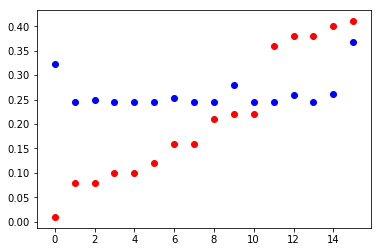

MSE                      = 0.0186985211669
MAE                      = 0.119318876521
r2_score                 = -0.117815524068    (best_value is 1)
explained_variance_score = 0.0313180268899    (best_value is 1)


In [98]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
y_pred = forest_grid.predict(x_hold)
predict_for_analize_fake = pd.DataFrame({'y_hold':y_hold, 'y_predict':y_pred})
# print('Анализ реальных aps с реальными значениями wc')
print('Данные hold')
data_analize_func(predict_for_analize_fake)

Анализ train


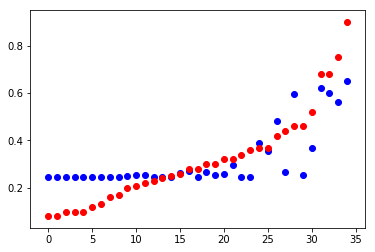

MSE                      = 0.0120150998599
MAE                      = 0.088020035979
r2_score                 = 0.685985293387    (best_value is 1)
explained_variance_score = 0.685991226232    (best_value is 1)


In [99]:
y_pred = forest_grid.predict(x_train)
predict_for_analize_fake = pd.DataFrame({'y_hold':y_train, 'y_predict':y_pred})
# print('Анализ реальных aps с реальными значениями wc')
print('Анализ train')
data_analize_func(predict_for_analize_fake)